# Example code to create a SpliceMap

In [2]:
import numpy as np
import pandas as pd
from kipoiseq.extractors import MultiSampleVCF
from splicemap.dataclasses import Junction
from splicemap import SpliceCountTable
import matplotlib.pyplot as plt

In [3]:
fasta_file = '/s/genomes/human/hg19/fasta/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa'
gtf_file = '/s/genomes/Gencode/Gencode_human/release_34/GRCh37_mapping/gencode.v34lift37.annotation.gtf.gz'

## 1) Read in example file

In [4]:
path = '/s/project/gtex-processed/mmsplice-scripts/data/processed/junction-annotation/Brain_Cortex_raw_count_table.csv'
ct = SpliceCountTable.read_csv(path)

### 1.1) Infer Strand (if no strand)
If strand information does not contained in count_table it can be infered by reference genome.

In [6]:
ct.df['Strand'] = '.' # removes strand information

In [7]:
ct.df['Strand'] = ct.df['Strand'].astype("category")

In [8]:
ct.infer_strand(fasta_file, progress=True)

100%|██████████| 1065286/1065286 [00:24<00:00, 44073.78it/s]
/data/nasif12/home_if12/wagnern/Projects/gitlab_gagneurlab/splicemap/splicemap/count_table.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i in junctions


In [9]:
ct.df.iloc[:,:7].rename(columns={
    ct.df.columns[4]: 'individual 1',
    ct.df.columns[5]: 'individual 2',
    ct.df.columns[6]: 'individual 3'
})

,Chromosome,Start,End,Strand,individual 1,individual 2,individual 3
junctions,,,,,,,
1:10895-10969:+,1,10895,10969,+,1,0,0
1:11211-12009:+,1,11211,12009,+,0,0,0
1:11671-12009:+,1,11671,12009,+,1,0,1
1:11844-12009:+,1,11844,12009,+,0,0,0
1:12227-12594:+,1,12227,12594,+,0,0,0
...,...,...,...,...,...,...,...
Y:58888289-58902586:+,Y,58888289,58902586,+,0,0,0
Y:58888289-58909682:-,Y,58888289,58909682,-,0,0,0
Y:58895447-58909682:-,Y,58895447,58909682,-,0,0,0


## 2) Use quality filters to generate a SpliceMap

Notes for provided quality filters in the splicemap package:

### 2.1) Median filter
We use 'event5_median_filter' and 'event3_median_filter', which filters for events/splice-sites that have a median count over a certain cutoff value. Note that results depend a lot on the choice of this cutoff value

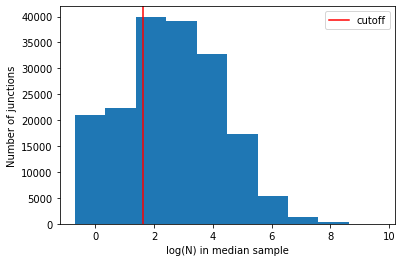

In [10]:
cutoff = 5

ct.plot_median_read_hist_event5()
plt.axvline(np.log(cutoff), 0, 1, label='cutoff', c='red')
plt.legend()

In [11]:
ct_psi5 = ct.event5_median_filter(cutoff=cutoff)
ct_psi3 = ct.event3_median_filter(cutoff=cutoff)

`event5_count_filter` and `event3_count_filter` uses GaussianMixture model (no hard cutoff). This underestimates. Reports lots of regions to be expressed, although they are not expressed
Therefore currently '_median_filter' is used, which uses a hard cutoff. As a cutoff for the GTEx data 50 was chosen|

### 2.2) Quantile filter
We first use 'quantile_filter', which filters for junctions that are observed in at least 5% of the samples

In [12]:
ct_psi5 = ct_psi5.quantile_filter()
ct_psi3 = ct_psi3.quantile_filter()

### 2.3) Infer annotation of junctions from standart annotation
This will infer the gene id, gene type as well as if the donor and acceptor site of the junction are annotated in the provided gtf file

In [13]:
ct_psi5.infer_annotation(gtf_file)

,,gene_name,gene_type,novel_junction,weak_site_donor,weak_site_acceptor,transcript_id
junctions,gene_id,,,,,,
1:763155-764382:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000670780.1_2;ENST00...
1:764484-787306:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000623808.3_2;ENST00000622921.1_2;ENST00...
1:764484-783033:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000609009.6_3;ENST00...
1:764484-776579:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000670780.1_2;ENST00000660797.1_2;ENST00...
1:783186-787306:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000670780.1_2;ENST00000661237.1_2;ENST00...
...,...,...,...,...,...,...,...
Y:21903374-21903620:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903743-21905047:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21905125-21906270:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000440077.5_4;ENST00000382806.6_3;ENST00...


In [14]:
ct_psi3.infer_annotation(gtf_file)

,,gene_name,gene_type,novel_junction,weak_site_donor,weak_site_acceptor,transcript_id
junctions,gene_id,,,,,,
1:762303-783033:+,ENSG00000228794,LINC01128,lncRNA,True,False,False,NaN
1:763155-764382:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000670780.1_2;ENST00...
1:763229-764382:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000657175.1_2
1:763233-764382:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000622921.1_2;ENST00000668541.1_2
1:764484-787306:+,ENSG00000228794,LINC01128,lncRNA,False,False,False,ENST00000623808.3_2;ENST00000622921.1_2;ENST00...
...,...,...,...,...,...,...,...
Y:21901548-21903203:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903374-21903620:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903743-21905047:-,ENSG00000012817,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...


### 2.4) Generate reference PSI (this will provide the SpliceMap)

In [19]:
splicemap_5 = ct_psi5.ref_psi5()
splicemap_3 = ct_psi3.ref_psi3()

#### SpliceMaps contain a dataframe and a name field. 
#### If no name is provided during SpliceMap generation the filename of the RNA-split read counts will be used. 
#### The user can define the name of the SpliceMap when reading in the split-read counts: 
#### SpliceCountTable.read_csv(path_ro_split_read_counts, name='name of SpliceMap')

In [30]:
print(splicemap_5.name)

Brain_Cortex_raw_count_table


In [26]:
splicemap_5.df

,,Chromosome,Start,End,Strand,splice_site,events,ref_psi,k,n,median_n,gene_name,gene_type,novel_junction,weak_site_donor,weak_site_acceptor,transcript_id
junctions,gene_id,,,,,,,,,,,,,,,,
1:763155-764382:+,ENSG00000228794,1,763155,764382,+,1:763155:+,1:763155-764382:+,1.000000,1297,1297,13.0,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000670780.1_2;ENST00...
1:764484-787306:+,ENSG00000228794,1,764484,787306,+,1:764484:+,1:764484-776579:+;1:764484-783033:+;1:764484-7...,0.306859,425,1385,13.5,LINC01128,lncRNA,False,False,False,ENST00000623808.3_2;ENST00000622921.1_2;ENST00...
1:764484-783033:+,ENSG00000228794,1,764484,783033,+,1:764484:+,1:764484-776579:+;1:764484-783033:+;1:764484-7...,0.602888,835,1385,13.5,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000609009.6_3;ENST00...
1:764484-776579:+,ENSG00000228794,1,764484,776579,+,1:764484:+,1:764484-776579:+;1:764484-783033:+;1:764484-7...,0.090253,125,1385,13.5,LINC01128,lncRNA,False,False,False,ENST00000670780.1_2;ENST00000660797.1_2;ENST00...
1:783186-787306:+,ENSG00000228794,1,783186,787306,+,1:783186:+,1:783186-784863:+;1:783186-787306:+,0.705502,654,927,8.0,LINC01128,lncRNA,False,False,False,ENST00000670780.1_2;ENST00000661237.1_2;ENST00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y:21903374-21903620:-,ENSG00000012817,Y,21903374,21903620,-,Y:21903620:-,Y:21901548-21903620:-;Y:21903374-21903620:-,0.993396,1053,1060,10.0,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903743-21905047:-,ENSG00000012817,Y,21903743,21905047,-,Y:21905047:-,Y:21903743-21905047:-,1.000000,1151,1151,10.0,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21905125-21906270:-,ENSG00000012817,Y,21905125,21906270,-,Y:21906270:-,Y:21905125-21906270:-;Y:21905279-21906270:-,0.975733,965,989,9.0,KDM5D,protein_coding,False,False,False,ENST00000440077.5_4;ENST00000382806.6_3;ENST00...


In [27]:
splicemap_3.df

,,Chromosome,Start,End,Strand,splice_site,events,ref_psi,k,n,median_n,gene_name,gene_type,novel_junction,weak_site_donor,weak_site_acceptor,transcript_id
junctions,gene_id,,,,,,,,,,,,,,,,
1:762303-783033:+,ENSG00000228794,1,762303,783033,+,1:783033:+,1:762303-783033:+;1:764484-783033:+;1:776753-7...,0.028377,25,881,8.5,LINC01128,lncRNA,True,False,False,NaN
1:763155-764382:+,ENSG00000228794,1,763155,764382,+,1:764382:+,1:763155-764382:+;1:763229-764382:+;1:763233-7...,0.970082,1297,1337,13.0,LINC01128,lncRNA,False,False,False,ENST00000608189.5_3;ENST00000670780.1_2;ENST00...
1:763229-764382:+,ENSG00000228794,1,763229,764382,+,1:764382:+,1:763155-764382:+;1:763229-764382:+;1:763233-7...,0.014211,19,1337,13.0,LINC01128,lncRNA,False,False,False,ENST00000657175.1_2
1:763233-764382:+,ENSG00000228794,1,763233,764382,+,1:764382:+,1:763155-764382:+;1:763229-764382:+;1:763233-7...,0.015707,21,1337,13.0,LINC01128,lncRNA,False,False,False,ENST00000622921.1_2;ENST00000668541.1_2
1:764484-787306:+,ENSG00000228794,1,764484,787306,+,1:787306:+,1:764484-787306:+;1:783186-787306:+;1:784982-7...,0.308194,425,1379,13.0,LINC01128,lncRNA,False,False,False,ENST00000623808.3_2;ENST00000622921.1_2;ENST00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y:21901548-21903203:-,ENSG00000012817,Y,21901548,21903203,-,Y:21901548:-,Y:21901548-21903203:-;Y:21901548-21903620:-,0.994243,1209,1216,11.0,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903374-21903620:-,ENSG00000012817,Y,21903374,21903620,-,Y:21903374:-,Y:21903374-21903620:-,1.000000,1053,1053,10.0,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...
Y:21903743-21905047:-,ENSG00000012817,Y,21903743,21905047,-,Y:21903743:-,Y:21903743-21905047:-,1.000000,1151,1151,10.0,KDM5D,protein_coding,False,False,False,ENST00000541639.5_6;ENST00000317961.8_6;ENST00...


## 3) Plotting features

In [28]:
vcf_file = '/s/project/gtex-processed/mmsplice-scripts/data/raw/gtex/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.vcf.gz'
vcf = MultiSampleVCF(vcf_file)

junction = '11:47600710-47600820:+'

### With 'plot_kn{5,3}', 'plot_psi{5,3}', and 'plot_psi{5,3}_variants' we can visualize outliers

<AxesSubplot:xlabel='variant', ylabel='ref_psi'>

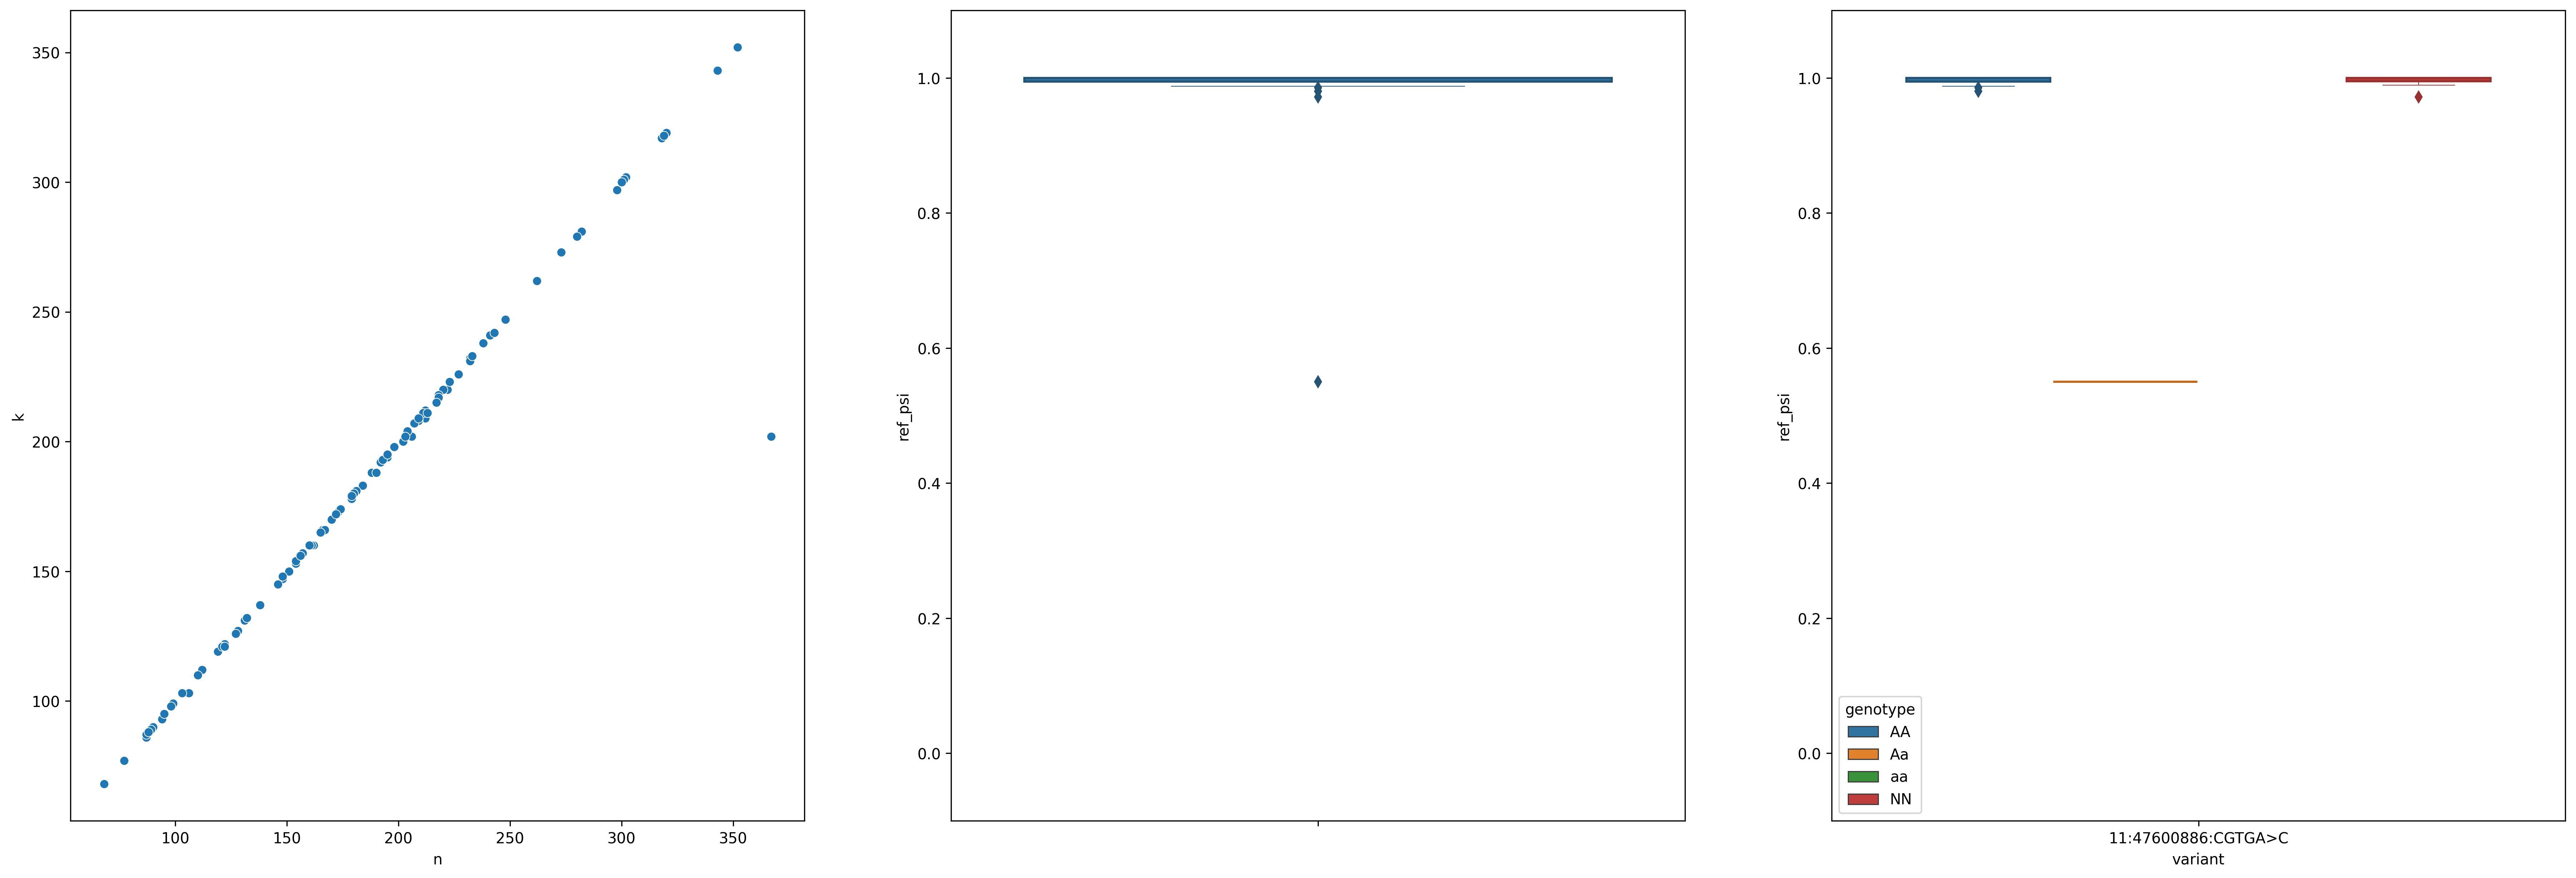

In [29]:
plt.figure(figsize=(30,10), dpi=300)
plt.subplot(1, 3, 1)
ct_psi5.plot_kn5(junction)

plt.subplot(1, 3, 2)
ct_psi5.plot_psi5(junction)

plt.subplot(1, 3, 3)
ct_psi5.plot_psi5_variants(junction, vcf)